**Preamble**

This is a **group** project. Please indicate the names of all group members below. 
Each group is to comprise *five* to *six* members.
To be clear, the group should submit ONE notebook.

Please acknowledge all sources. 

Sources (if applicable) : https://www.gurobi.com/jupyter_models/supply-network-design/

# Minimum Cost Network Flow Problem

Project objectives:

i. Investigate the application of minimum cost network flow (MCNF) in solving real-world problems.

ii. Solve specific instances using both `PuLP` and `networkx` for comparison and analysis.

----------------

## Problem Statement

<font color = 'blue'>Video Link: [pP4GVzM828Y](https://youtu.be/pP4GVzM828Y)</font>

Following is the original data from Gurobi

Data Link: [supply_network_design](https://colab.research.google.com/github/Gurobi/modeling-examples/blob/master/supply_network_design/supply_network_design_1.ipynb)

### Problem Description
In this problem, we have six end customers, each with a known demand for a product. Customer demand can be satisfied from a set of four depots, or directly from a set of two factories. Each depot can support a maximum volume of product moving through it, and each factory can produce a maximum amount of product. There are known costs associated with transporting the product, from a factory to a depot, from a depot to a customer, or from a factory directly to a customer.

The question to be answered is how to satisfy the demands of the end customers while minimizing shipping costs.

In [1]:
# Create dictionaries to capture factory supply limits, depot throughput limits, and customer demand.
supply = dict({'F1': 150000,
               'F2': 200000})

through = dict({'D1': 70000,
                'D2': 50000,
                'D3': 100000,
                'D4': 40000})

demand = dict({'C1': 50000,
               'C2': 10000,
               'C3': 40000,
               'C4': 35000,
               'C5': 60000,
               'C6': 20000})

# Create a dictionary to capture shipping costs.
costs = dict({
    ('F1', 'D1'): 0.5,
    ('F1', 'D2'): 0.5,
    ('F1', 'D3'): 1.0,
    ('F1', 'D4'): 0.2,
    ('F1', 'C1'): 1.0,
    ('F1', 'C3'): 1.5,
    ('F1', 'C4'): 2.0,
    ('F1', 'C6'): 1.0,
    ('F2', 'D2'): 0.3,
    ('F2', 'D3'): 0.5,
    ('F2', 'D4'): 0.2,
    ('F2', 'C1'): 2.0,
    ('D1', 'C2'): 1.5,
    ('D1', 'C3'): 0.5,
    ('D1', 'C5'): 1.5,
    ('D1', 'C6'): 1.0,
    ('D2', 'C1'): 1.0,
    ('D2', 'C2'): 0.5,
    ('D2', 'C3'): 0.5,
    ('D2', 'C4'): 1.0,
    ('D2', 'C5'): 0.5,
    ('D3', 'C2'): 1.5,
    ('D3', 'C3'): 2.0,
    ('D3', 'C5'): 0.5,
    ('D3', 'C6'): 1.5,
    ('D4', 'C3'): 0.2,
    ('D4', 'C4'): 1.5,
    ('D4', 'C5'): 0.5,
    ('D4', 'C6'): 1.5
})

### Constraints

- **Factory output**: Flow of goods from a factory must respect maximum capacity.

\begin{equation}
\sum_{t \in \text{Cities}}{\text{flow}_{f,t}} \leq \text{supply}_{f} \quad \forall f \in \text{Factories}
\end{equation}

- **Customer demand**: Flow of goods must meet customer demand.

\begin{equation}
\sum_{s \in \text{Cities}}{\text{flow}_{s,c}} = \text{demand}_{c} \quad \forall c \in \text{Customers}
\end{equation}

- **Depot flow**: Flow into a depot equals flow out of the depot.

\begin{equation}
\sum_{s \in \text{Cities}}{\text{flow}_{s,d}} = 
\sum_{t \in \text{Cities}}{\text{flow}_{d,t}}
\quad \forall d \in \text{Depots}
\end{equation}

- **Depot capacity**: Flow into a depot must respect depot capacity.

\begin{equation}
\sum_{s \in \text{Cities}}{\text{flow}_{s,d}} \leq \text{through}_{d}
\quad \forall d \in \text{Depots}
\end{equation}

In [ ]:
# packages used
import pulp as pulp
import networkx as nx

import time
import sys
import random
import time

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import pickle
import itertools

from collections import defaultdict

from sklearn.linear_model import LinearRegression as LR

------------------

### `PuLP` Routine

In [2]:
# WRITE YOUR CODE HERE
import pulp as pulp
from collections import defaultdict
import time
import sys

# hide warnings
import warnings
warnings.filterwarnings('ignore')

def create_lp(supply, through, demand, costs, verbose = 1):
    
    # Hide print
    original_stdout = sys.stdout
    if verbose == 0:
        sys.stdout = None
        
    # Create the LP problem
    problem = pulp.LpProblem("supply network design", pulp.LpMinimize)
    
    # save nodes
    factories = list(supply.keys())
    depots = list(through.keys())
    customers = list(demand.keys())

    # save neighbors 
    neighborI = defaultdict(list)
    neighborJ = defaultdict(list)
    for i in costs.keys():
        neighborI[i[0]].append(i[1])
        neighborJ[i[1]].append(i[0])


    # Define the decision variables
    flow = pulp.LpVariable.dicts("flow", costs, lowBound=0, cat='Continuous')

    # Define the objective function (minimize cost)
    problem += pulp.lpSum([costs[edge] * flow[edge] for edge in costs.keys()])

    # Define factory output constraints
    for F in factories:
        problem += pulp.lpSum([flow[(F,J)] for J in neighborI[F]]) <= supply[F], f"factory output{F}"

    # Define customer demand constraints
    for C in customers:
        problem += pulp.lpSum([flow[(I,C)] for I in neighborJ[C]]) == demand[C], f"customer demand{C}"

    # Define depot flow constraints
    for D in depots:
        problem += pulp.lpSum([flow[(I,D)] for I in neighborJ[D]]) == pulp.lpSum([flow[(D,J)] for J in neighborI[D]]), f"depot flow{D}"

    # Define depot capacity constraints
    for D in depots:
        problem += pulp.lpSum([flow[(I,D)] for I in neighborJ[D]]) <= through[D], f"depot capacity{D}"
        
    print(f'Assignment Problem initialized with {len(flow)} variables and {len(factories)+len(customers)+2*len(depots)} constraints!') 
    
    # Recover print
    sys.stdout = original_stdout
    
    return problem, flow

def solve_lp(problem,flow,showCons = 0,verbose = 1):
    
    # Hide print
    original_stdout = sys.stdout
    if verbose == 0:
        sys.stdout = None
    
    # Solve the problem
    print(f'Solving...')
    start_time = time.time()
    problem.solve()
    end_time = time.time()
    during_time = end_time - start_time
    print("LP calculation successful!")
    print(f'Time cost : {during_time}')

    # Print the results
    print("Status:", pulp.LpStatus[problem.status])
    print()
    print("***********************************")
    print()

    print(f'Min cost : {pulp.value(problem.objective)}')
    # Result
    for edge in flow:
        if flow[edge].value() != 0:
            print(f"Flow from {edge[0]} to {edge[1]}: {flow[edge].value()}")
    if showCons == 1:
        for name, constraint in problem.constraints.items():
            print(f"{name}: {constraint.value()}")
    
    # Recover print
    sys.stdout = original_stdout
    
    return during_time

In [3]:
problem,flow = create_lp(supply, through, demand, costs, verbose = 1)
solve_lp(problem, flow, verbose = 1)

Assignment Problem initialized with 29 variables and 16 constraints!
Solving...
LP calculation successful!
Time cost : 0.42133331298828125
Status: Optimal

***********************************

Min cost : 198500.0
Flow from F1 to D4: 40000.0
Flow from F1 to C1: 50000.0
Flow from F1 to C6: 20000.0
Flow from F2 to D2: 50000.0
Flow from F2 to D3: 55000.0
Flow from D2 to C2: 10000.0
Flow from D2 to C4: 35000.0
Flow from D2 to C5: 5000.0
Flow from D3 to C5: 55000.0
Flow from D4 to C3: 40000.0


0.42133331298828125

------------------

### `networkx` Routine

In [4]:
# WRITE YOUR CODE HERE
import networkx as nx
import matplotlib.pyplot as plt

def create_net(supply, through, demand, costs, verbose = 1):
    
    # Hide print
    original_stdout = sys.stdout
    if verbose == 0: sys.stdout = None
    
    G = nx.DiGraph()

    # Add supply nodes (factories)
    for factory, cap in supply.items():
        G.add_node(factory, demand=-cap)  # Negative demand for sources (factories)

    # Add depot nodes (split into input and output nodes)
    for depot, cap in through.items():
        G.add_node(f"{depot}_in", demand=0)  # Depot input node
        G.add_node(f"{depot}_out", demand=0)  # Depot output node
        # Edge between input and output with depot capacity
        G.add_edge(f"{depot}_in", f"{depot}_out", weight=0, capacity=cap)

    # Add demand nodes (customers)
    for customer, dem in demand.items():
        G.add_node(customer, demand=dem)  # Positive demand for sinks (customers)

    # Add edges with costs (modified to connect to depot input/output nodes)
    for (i, j), cost in costs.items():
        # If edge goes to a depot, connect to the depot's input node
        if j in through:
            G.add_edge(i, f"{j}_in", weight=cost, capacity=float('inf'))
        # If edge comes from a depot, connect from the depot's output node
        elif i in through:
            G.add_edge(f"{i}_out", j, weight=cost, capacity=float('inf'))
        # Otherwise, it's a direct factory-customer edge
        else:
            G.add_edge(i, j, weight=cost, capacity=float('inf'))
    
    excess_supply = sum(supply.values()) - sum(demand.values())

    if excess_supply != 0:
        G.add_node('dummy', demand = excess_supply, capacity = float('inf'), color = 'blue')
    
    for factory in supply:
        if 'dummy' in G.nodes():
            G.add_edge(factory, 'dummy', weight=0, capacity=float('inf'))
    
    print(f'Assignment Problem initialized with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges!')
    
    # Recover print
    sys.stdout = original_stdout
    
    return G

def solve_network(G,verbose = 1):
    
    # Hide print
    original_stdout = sys.stdout
    if verbose == 0: sys.stdout = None
    
    print(f'Solving...')
    try:
        start_time = time.time()
        flowCost, flowDict = nx.network_simplex(G)
        end_time = time.time()
        during_time = end_time - start_time
        print("Flow calculation successful!")
        print(f'Time cost : {during_time}')

        # Print the results
        print()
        print("***********************************")
        print()
        print(f"Minimum Cost : {flowCost}")

        for i in flowDict:
            for j in flowDict[i]:
                if flowDict[i][j] != 0:
                    print(f"Flow from {i} to {j}: {flowDict[i][j]}")
                    
        # Recover print
        sys.stdout = original_stdout
        
        return during_time

    except Exception as e:
        print(f"Error during flow calculation: {e}")
        
        # Recover print
        sys.stdout = original_stdout
        
        return -1

In [5]:
G = create_net(supply, through, demand, costs, verbose = 1)
solve_network(G, verbose = 1)

Assignment Problem initialized with 17 nodes and 35 edges!
Solving...
Flow calculation successful!
Time cost : 0.002892732620239258

***********************************

Minimum Cost : 198500.0
Flow from F1 to D4_in: 40000
Flow from F1 to C1: 50000
Flow from F1 to C6: 20000
Flow from F1 to dummy: 40000
Flow from F2 to D2_in: 50000
Flow from F2 to D3_in: 55000
Flow from F2 to dummy: 95000
Flow from D2_in to D2_out: 50000
Flow from D2_out to C2: 10000
Flow from D2_out to C4: 35000
Flow from D2_out to C5: 5000
Flow from D3_in to D3_out: 55000
Flow from D3_out to C5: 55000
Flow from D4_in to D4_out: 40000
Flow from D4_out to C3: 40000


0.002892732620239258

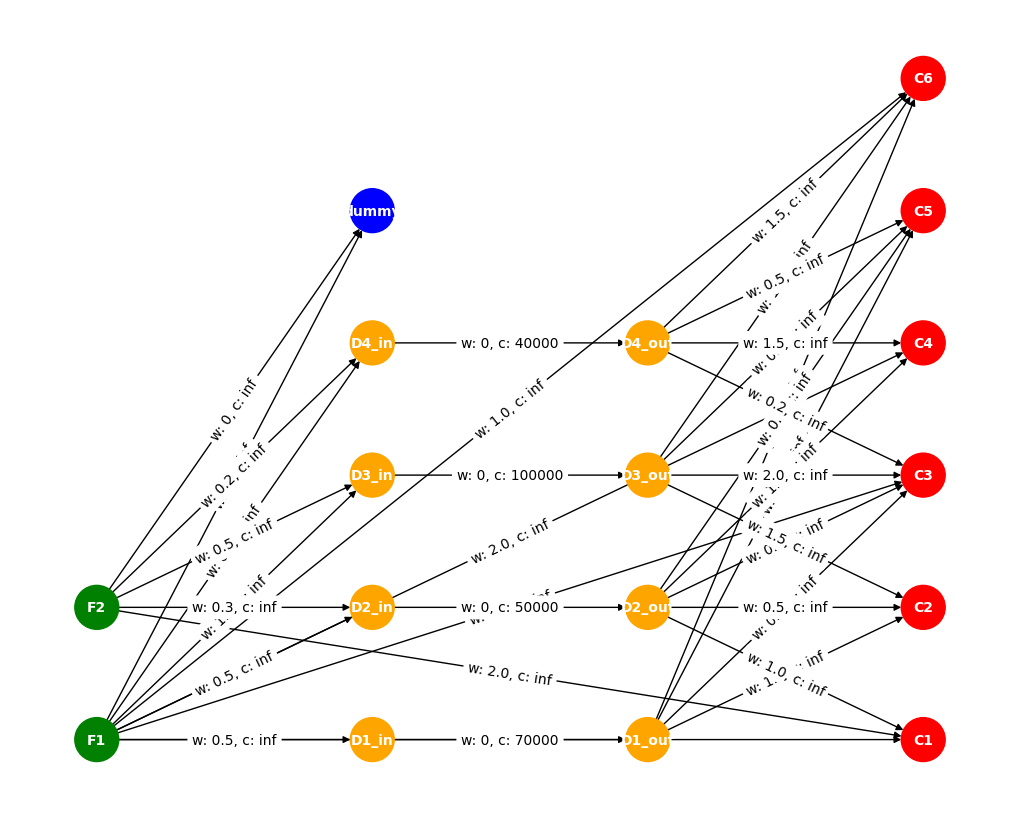

In [6]:
import matplotlib.pyplot as plt
# Create a position dictionary for nodes
pos = {}

# Supply nodes on the left (x=0)
for idx, node in enumerate(supply):
    pos[node] = (0, idx)

# Through (intermediate) nodes in the middle
for idx, node in enumerate(through):
    pos[f"{node}_in"] = (1, idx)  # Input depot nodes at x = 1
    pos[f"{node}_out"] = (2, idx)  # Output depot nodes at x = 2

# Demand nodes on the right (x=2)
for idx, node in enumerate(demand):
    pos[node] = (3, idx)

# Handle the dummy node position and attributes
if 'dummy' in G.nodes():
    pos['dummy'] = (1, len(through))  # Position it below the Input depot nodes
    G.nodes['dummy']['color'] = 'blue'     # Color for the dummy node

# Create color mapping for each node category
node_colors = []
for node in G.nodes():
    if node in supply:
        node_colors.append('green')  # Color for supply nodes
    elif node.replace('_in', '').replace('_out', '') in through:
        node_colors.append('orange')  # Color for through nodes
    elif node in demand:
        node_colors.append('red')    # Color for demand nodes
    elif node == 'dummy':
        node_colors.append('blue')    # Color for dummy node
    else:
        node_colors.append('lightgray')  # Default color

# Draw the graph
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1000, font_size=10, font_color='white', font_weight='bold')

# Draw edge labels (weights and capacities)
edge_labels = nx.get_edge_attributes(G, 'weight')
capacity_labels = nx.get_edge_attributes(G, 'capacity')

# Combine weights and capacities into a single label dictionary
combined_labels = {edge: f"w: {edge_labels[edge]}, c: {capacity_labels[edge]}" for edge in G.edges()}

# Draw edge labels (weights and capacities)
nx.draw_networkx_edge_labels(G, pos, edge_labels=combined_labels)

# Display the graph
plt.show()

-------
# Generate random data to more tests

In [7]:
import random

# Simulation
def generate_random_data(num_factories, num_depots, num_customers, ratio = 1,
                         min_supply = 10000, max_supply = 500000, 
                         min_demand = 10000, max_demand = 100000, 
                         min_cost= 1, max_cost = 10):
    """
    Generates random supply, through, demand, and costs dictionaries.

    Args:
        num_factories: Number of factories.
        num_depots: Number of depots.
        num_customers: Number of customers.
        min_supply: Minimum supply per factory.
        max_supply: Maximum supply per factory.
        min_demand: Minimum demand per customer.
        max_demand: Maximum demand per customer.
        min_cost: Minimum transportation cost.
        max_cost: Maximum transportation cost.
        ratio: the ratio of connected edges to all possible edges
        
    Notes
    -----
    Due network_simplex (in networkx) is not guaranteed to work if edge weights or demands
    are floating point numbers (overflows and roundoff errors can
    cause problems). So we only generate integer cost


    Returns:
        A tuple of supply, through, demand, and costs dictionaries.
    """

    # Generate random supply for factories
    supply = {f"F{i+1}": random.randint(min_supply, max_supply) for i in range(num_factories)}

    # Generate random demand for customers
    min_demand = min(min_demand, min_supply * num_factories // num_customers)
    max_demand = min(max_demand, max_supply * num_factories // num_customers)
    demand = {f"C{i+1}": random.randint(min_demand, max_demand) for i in range(num_customers)}

    # Calculate total demand and supply
    total_demand = sum(demand.values())
    total_supply = sum(supply.values())

    # Adjust supply if total demand exceeds total supply
    if total_demand > total_supply:
        for factory, supply_value in supply.items():
            supply[factory] += (total_demand - total_supply)//len(supply) + 1


    # Generate random through capacities for distribution centers
    multiplier = num_depots  // num_factories + 1 # balance the capacities with numbers of suppliers and depots
    through = {f"D{i+1}": random.randint(min_supply // multiplier, max_supply // multiplier) for i in range(num_depots)}

    # Generate random transportation costs
    costs = {}
    for factory in supply.keys():
        for depots in through.keys():
            if random.random() <= ratio:
                costs[(factory, depots)] = round(random.randint(min_cost, max_cost), 1)
        for customer in demand.keys():
            if random.random() <= ratio:
                costs[(factory, customer)] = round(random.randint(min_cost, max_cost), 1)
                
    for depots in through.keys():
        for customer in demand.keys():
            if random.random() <= ratio:
                costs[(depots, customer)] = round(random.randint(min_cost, max_cost), 1)

    return supply, through, demand, costs

In [8]:
if __name__ == "__main__":
    # Example usage
    complexity = 100
    num_factories = 2 * complexity 
    num_depots = 4 * complexity 
    num_customers = 6 * complexity 
    supply, through, demand, costs = generate_random_data(num_factories, num_depots, num_customers,ratio = 0.1)

### `Pulp` Routine

In [9]:
problem,flow = create_lp(supply, through, demand, costs, verbose = 1)
solve_lp(problem, flow, verbose = 1)

Assignment Problem initialized with 43988 variables and 1600 constraints!
Solving...
LP calculation successful!
Time cost : 1.8603298664093018
Status: Optimal

***********************************

Min cost : 35632104.0
Flow from F2 to C69: 87516.0
Flow from F2 to C142: 54591.0
Flow from F2 to C199: 86354.0
Flow from F2 to C201: 68771.0
Flow from F2 to C301: 13783.0
Flow from F2 to C567: 51707.0
Flow from F3 to C157: 24971.0
Flow from F3 to C280: 68647.0
Flow from F3 to C437: 22196.0
Flow from F3 to C442: 47481.0
Flow from F3 to C592: 16074.0
Flow from F4 to C48: 5228.0
Flow from F4 to C121: 17293.0
Flow from F4 to C375: 86587.0
Flow from F4 to C466: 38847.0
Flow from F4 to C597: 56589.0
Flow from F5 to C320: 26162.0
Flow from F5 to C562: 89180.0
Flow from F6 to C135: 54825.0
Flow from F6 to C151: 75246.0
Flow from F6 to C523: 14034.0
Flow from F6 to C527: 4095.0
Flow from F7 to C3: 86898.0
Flow from F7 to C66: 9646.0
Flow from F7 to C81: 59899.0
Flow from F7 to C206: 79649.0
Flow from 

1.8603298664093018

### `Networkx` Routine

In [10]:
G = create_net(supply, through, demand, costs, verbose = 1)
solve_network(G, verbose = 1)

Assignment Problem initialized with 1601 nodes and 44588 edges!
Solving...
Flow calculation successful!
Time cost : 1.4113914966583252

***********************************

Minimum Cost : 35632104
Flow from F1 to C520: 23628
Flow from F1 to C589: 33260
Flow from F1 to dummy: 205196
Flow from F2 to D187_in: 24000
Flow from F2 to C142: 82310
Flow from F2 to C199: 91980
Flow from F2 to C201: 41485
Flow from F2 to C408: 57816
Flow from F2 to C464: 32026
Flow from F2 to C567: 33105
Flow from F3 to C61: 14718
Flow from F3 to C437: 22196
Flow from F3 to C592: 16074
Flow from F3 to dummy: 290162
Flow from F4 to D8_in: 36147
Flow from F4 to D323_in: 117113
Flow from F4 to C121: 17293
Flow from F4 to C375: 86587
Flow from F4 to C466: 38847
Flow from F4 to C597: 56589
Flow from F5 to dummy: 258049
Flow from F6 to D106_in: 6386
Flow from F6 to D151_in: 13964
Flow from F6 to C135: 58240
Flow from F6 to C151: 75246
Flow from F6 to C163: 47041
Flow from F7 to C3: 86898
Flow from F7 to C35: 60501
Flow

1.4113914966583252

-------
## Explore the relationship among 
complexity, num_factories,num_depots,num_customers,ratio and time

In [11]:
import itertools

params_grid = {
    'complexity' : [2 * i for i in range(1,6)],
    'num_factories' : [2 * i for i in range(1,6)],
    'num_depots' : [2 * i for i in range(1,6)],
    'num_customers' : [2 * i for i in range(1,6)],
    'ratio' : [i / 5 for i in range(2,6)]
}
time_table = {
    'LP': {},
    'NET': {}
}

# Create a list of all parameter values
param_values = list(params_grid.values())

# Generate all possible combinations of parameter values
combinations = list(itertools.product(*param_values))

# Iterate through the combinations and print them
for i,combination in enumerate(combinations):
    # params
    complexity = combination[0]
    num_factories = combination[1] * complexity 
    num_depots = combination[2] * complexity 
    num_customers = combination[3] * complexity
    ratio = combination[4]
    
    # 5 times averaging
    time_lp = []
    time_net = []
    for _ in range(5):
        supply, through, demand, costs = generate_random_data(num_factories = num_factories, 
                                                              num_depots = num_depots,
                                                              num_customers = num_customers,
                                                              ratio = ratio)
        # LP
        problem,flow = create_lp(supply, through, demand, costs, verbose = 0)
        time_lp.append(solve_lp(problem, flow, verbose = 0))

        # Network
        G = create_net(supply, through, demand, costs, verbose = 0)
        time_net.append(solve_network(G, verbose = 0))
       
    time_table['LP'][(num_factories, num_depots, num_customers, ratio)] = round(sum(time_lp)/5, 4)
    time_table['NET'][(num_factories, num_depots, num_customers, ratio)] = round(sum(time_net)/5, 4)
    
    print(i) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


In [15]:
# save as pkl
import pickle
f_save = open('time_table.pkl','wb')
pickle.dump(time_table,f_save)
f_save.close()

In [15]:
# read pkl
import pickle
f_read = open('time_table.pkl','rb')
time_table = pickle.load(f_read)
f_read.close()

In [16]:
import pandas as pd
lp_list = [[i for i in key] + [value] for key, value in time_table['LP'].items()]
net_list = [[i for i in key] + [value] for key, value in time_table['NET'].items()]
df_lp = pd.DataFrame(lp_list, columns=['num_factories', 'num_depots', 'num_customers', 'ratio','time'])
df_net = pd.DataFrame(net_list, columns=['num_factories', 'num_depots', 'num_customers', 'ratio','time'])

# Clear outliers (time < 0), which exist when model is infeasible
df_lp_d = df_lp[df_lp['time'] > 0]
df_net_d = df_net[df_net['time'] > 0]

In [18]:
df_lp_d.head()

,num_factories,num_depots,num_customers,ratio,time
0,4,4,4,0.4,0.0733
1,4,4,4,0.6,0.0637
2,4,4,4,0.8,0.0737
3,4,4,4,1.0,0.0729
4,4,4,8,0.4,0.0882


In [19]:
df_net_d.head()

,num_factories,num_depots,num_customers,ratio,time
1,4,4,4,0.6,0.0016
2,4,4,4,0.8,0.0016
3,4,4,4,1.0,0.0014
5,4,4,8,0.6,0.0030
6,4,4,8,0.8,0.0032


----------
### Correlation coefficient matrix

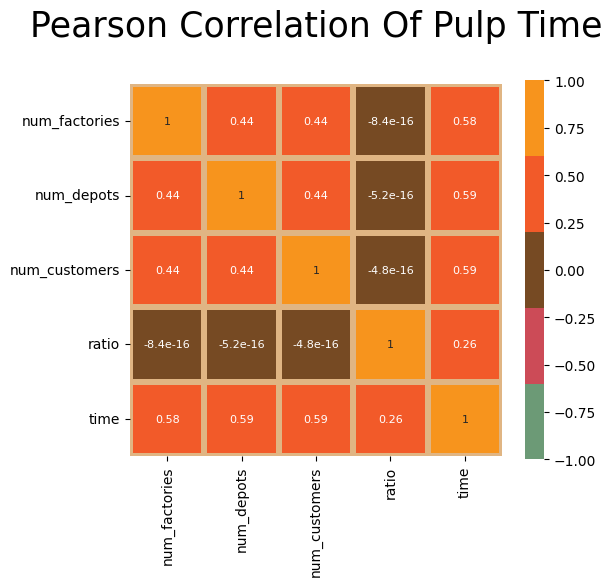

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
# correlation coefficient matrix
palette_cmap = ["#6c9a76","#cc4b57","#764a23","#f25a29","#f7941d"]
lp_corr = df_lp_d.copy()

plt.subplots(figsize =(6, 6))

sns.heatmap(lp_corr.corr(), cmap = palette_cmap, square=True, cbar_kws=dict(shrink =.82), 
            annot=True, vmin=-1, vmax=1, linewidths=3,linecolor='#e0b583',annot_kws=dict(fontsize =8))
plt.title("Pearson Correlation Of Pulp Time\n", fontsize=25)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

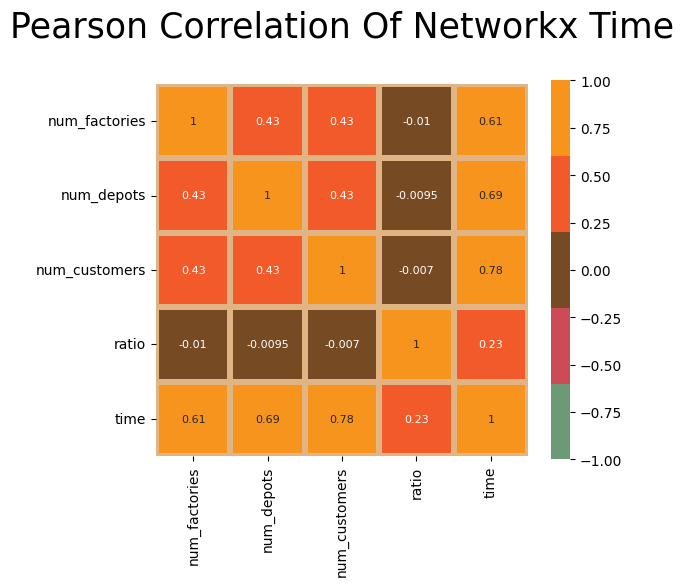

In [26]:
# correlation coefficient matrix
palette_cmap = ["#6c9a76","#cc4b57","#764a23","#f25a29","#f7941d"]
net_corr = df_net_d.copy()

plt.subplots(figsize =(6, 6))

sns.heatmap(net_corr.corr(), cmap = palette_cmap, square=True, cbar_kws=dict(shrink =.82), 
            annot=True, vmin=-1, vmax=1, linewidths=3,linecolor='#e0b583',annot_kws=dict(fontsize =8))
plt.title("Pearson Correlation Of Networkx Time\n", fontsize=25)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

------------
### Multiple linear regression

In [27]:
from sklearn.linear_model import LinearRegression as LR
LR_lp = LR()
LR_lp.fit(df_lp_d.iloc[:,:4],df_lp_d['time'])

print("coefficients:",LR_lp.coef_)
print("intercept:",LR_lp.intercept_)

coefficients: [0.00152837 0.00163439 0.00157908 0.14933081]
intercept: -0.09124197983149904


In [28]:
LR_net = LR()
LR_net.fit(df_net_d.iloc[:,:4],df_net_d['time'])

print("coefficients:",LR_net.coef_)
print("intercept:",LR_net.intercept_)

coefficients: [0.00049219 0.00075968 0.00109295 0.0571865 ]
intercept: -0.07433348340434442


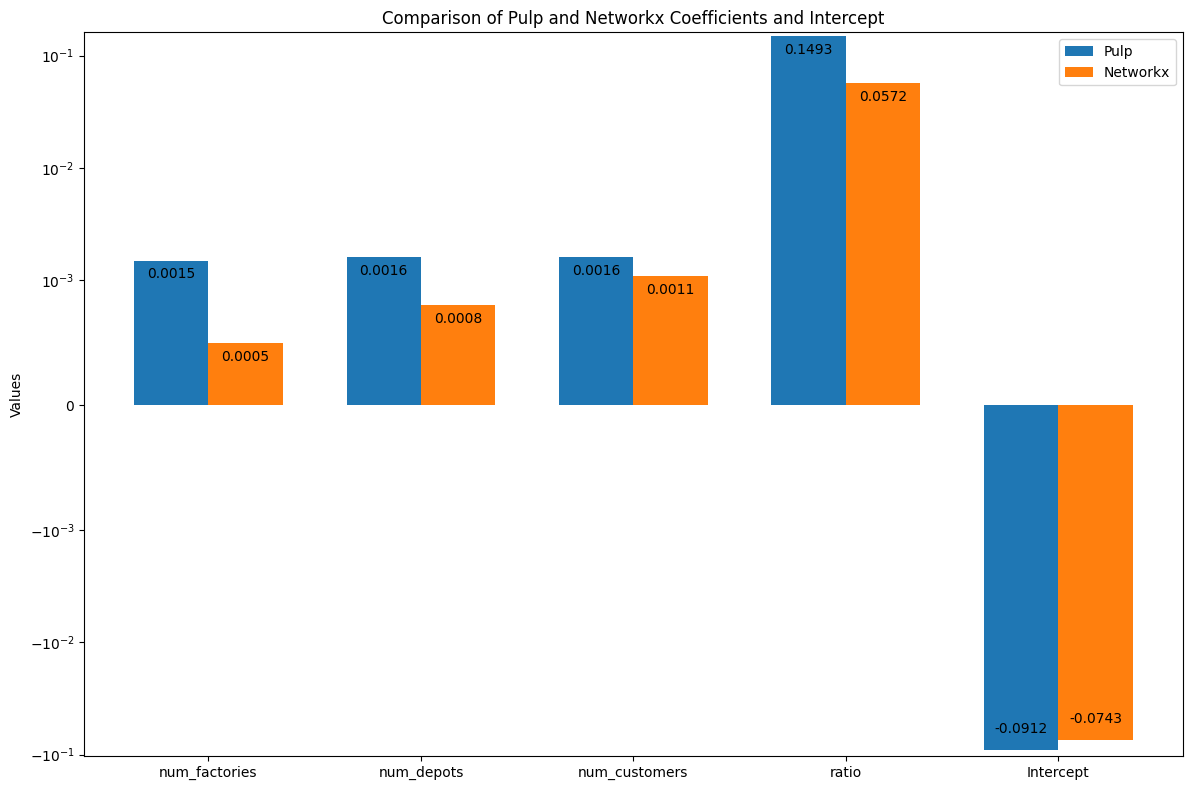

In [29]:
import matplotlib.pyplot as plt
import numpy as np

categories = ['A', 'B', 'C', 'D']
values1 = [25, 40, 30, 55]
values2 = [20, 35, 25, 45]

# Labels for the x-axis
categories  = ['num_factories', 'num_depots', 'num_customers', 'ratio', 'Intercept']

# Data for LP and Net
lp_data = [0.00152837, 0.00163439, 0.00157908, 0.14933081, -0.09124197983149904]
net_data = [0.00049219, 0.00075968, 0.00109295, 0.0571865, -0.07433348340434442]

lp_data = [round(i,4) for i in lp_data]
net_data = [round(i,4) for i in net_data]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2,lp_data, width, label='Pulp')
rects2 = ax.bar(x + width/2, net_data, width, label='Networkx')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        p = -15 if height > 0 else 10
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, p),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

ax.set_title('Comparison of Pulp and Networkx Coefficients and Intercept')
ax.set_ylabel('Values')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

fig.tight_layout()
plt.yscale('symlog',linthresh=0.001)
plt.show()